# Task-4:Sales Prediction

## Importing libraries

In [142]:
#General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error

## Importing Data

In [10]:
df=pd.read_csv("advertising.csv")

In [12]:
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


## Data Preprocessing

### Missing value check

In [18]:
df.isna().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

No missing values to impute

### Outliers check

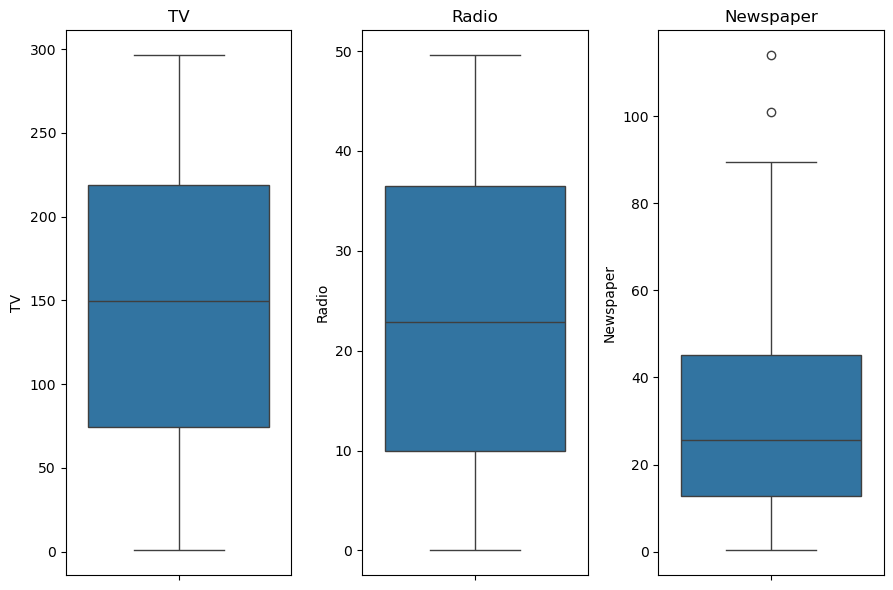

In [23]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

Only 2 outliers in newespaper.

## EDA

In [69]:
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


### Skewness Check

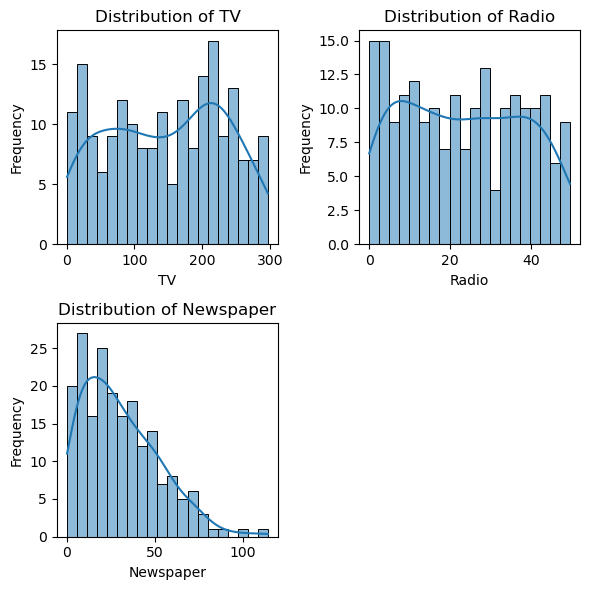

In [64]:
plt.figure(figsize=(6, 6))

for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Only newspaper advertisement is right skewed due to the presence of 2 outliers detected earlier.

### Validity of outliers

In [89]:
Q1 = df["Newspaper"].quantile(0.25)
Q3 = df["Newspaper"].quantile(0.75)
IQR = Q3 - Q1
upper_whisker = Q3 + 1.5 * IQR
df_filtered = df[df["Newspaper"] > upper_whisker][["Newspaper","Sales"]]
df_filtered

,Newspaper,Sales
16,114.0,12.5
101,100.9,23.8


High advertisement can still result in low sales i.e. outliers are justified and realistically acceptable.

### Correlation heatmap

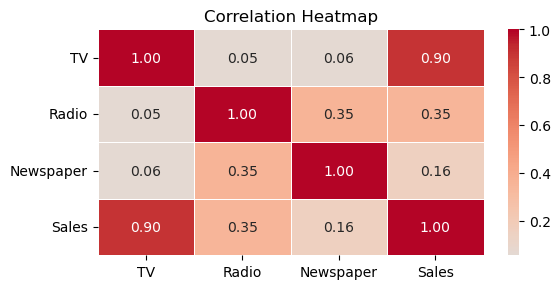

In [113]:
corr_matrix = df.corr()

plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

We see correlation between features is very low i.e. no chance of multicollinearity.

## Train - Test Split

In [128]:
X=df.drop("Sales",axis=1)
y=df["Sales"]

### Feature Scaling(Robust scaling)

In [130]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

### 80-20 Splitting

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Selection

In [144]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR()}


### Model training

In [151]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"   {name}")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE     : {mae:.4f}\n")

   Linear Regression
   R² Score: 0.9059
   MAE     : 1.2748

   Decision Tree
   R² Score: 0.8899
   MAE     : 1.2400

   Random Forest
   R² Score: 0.9535
   MAE     : 0.9180

   SVR
   R² Score: 0.8868
   MAE     : 1.4836



### Final model selection and hyperparameter tuning

We choose the Random foresrt Rewgressor model and do hyperparameter tunng for the model

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='r2', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [160]:
y_pred = best_rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nFinal Tuned Random Forest Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE     : {mae:.4f}")



Final Tuned Random Forest Performance:
R² Score: 0.9544
MAE     : 0.9061


Minimal increase in r2 score due to hyperparameter tuning

## Final predictions

In [168]:
pred=best_rf.predict(X)

In [177]:
results=pd.DataFrame({"Actual Sales":df["Sales"],"Predicted Sales":np.round(pred,1)})
results

,Actual Sales,Predicted Sales
0,22.1,22.0
1,10.4,10.7
2,12.0,10.1
3,16.5,16.6
4,17.9,17.8
...,...,...
195,7.6,8.4
196,14.0,13.4
197,14.8,15.7
198,25.5,25.3
